In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# --- Load and Basic Cleaning ---
file_path = '../data/raw/MachineLearningRating_v3.txt'
df = pd.read_csv(file_path, delimiter='|')
df.columns = df.columns.str.lower().str.replace(' ', '_')

# --- Feature Engineering ---
# Create 'vehicle_age' feature
# Using a fixed current year for reproducibility
current_year = 2015 
df['vehicle_age'] = current_year - df['registrationyear']
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: max(x, 0)) # Ensure no negative age

# Simplify boolean-like columns
df['has_alarm'] = df['alarmimmobiliser'].apply(lambda x: 1 if x == 'Y' else 0)
df['has_tracker'] = df['trackingdevice'].apply(lambda x: 1 if x == 'Y' else 0)

# --- Define Target and Features ---
# For this model, we will predict claim severity for policies that had a claim.
claims_df = df[df['totalclaims'] > 0].copy()

# Log-transform the target variable to handle skewness
claims_df['log_totalclaims'] = np.log1p(claims_df['totalclaims'])

# Select features for the model
# We'll start with a reasonable subset. You can add more later.
features = [
    'province', 'gender', 'vehicle_age', 'customvalueestimate', 
    'calculatedpremiumperterm', 'make', 'bodytype', 'has_alarm', 'has_tracker'
]
target = 'log_totalclaims'

X = claims_df[features]
y = claims_df[target]

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

C:\Users\foziya fetudin\AppData\Local\Temp\ipykernel_20664\1389609558.py:14: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='|')


Training set shape: (2230, 9)
Test set shape: (558, 9)


In [5]:
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Create preprocessing pipelines for both feature types
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Use median for robustness to outliers
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) # handle_unknown is crucial
])

# Create the master preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Define Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

results = {}

# --- Train and Evaluate Each Model ---
for name, model in models.items():
    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Train the model
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred_log = pipeline.predict(X_test)
    
    # Inverse transform the predictions to get the actual claim amount
    y_pred = np.expm1(y_pred_log)
    y_test_actual = np.expm1(y_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
    r2 = r2_score(y_test_actual, y_pred)
    
    results[name] = {'RMSE': rmse, 'R2 Score': r2, 'pipeline': pipeline}
    print(f"--- {name} ---")
    print(f"  RMSE: {rmse:,.2f} Rand")
    print(f"  R2 Score: {r2:.4f}")

c:\Users\foziya fetudin\acis-insurance-analytics\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Linear Regression ---
  RMSE: 44,091.69 Rand
  R2 Score: -0.2088


c:\Users\foziya fetudin\acis-insurance-analytics\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


--- Random Forest ---
  RMSE: 36,304.75 Rand
  R2 Score: 0.1805
--- XGBoost ---
  RMSE: 37,975.73 Rand
  R2 Score: 0.1033


c:\Users\foziya fetudin\acis-insurance-analytics\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


c:\Users\foziya fetudin\acis-insurance-analytics\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- SHAP Feature Importance ---


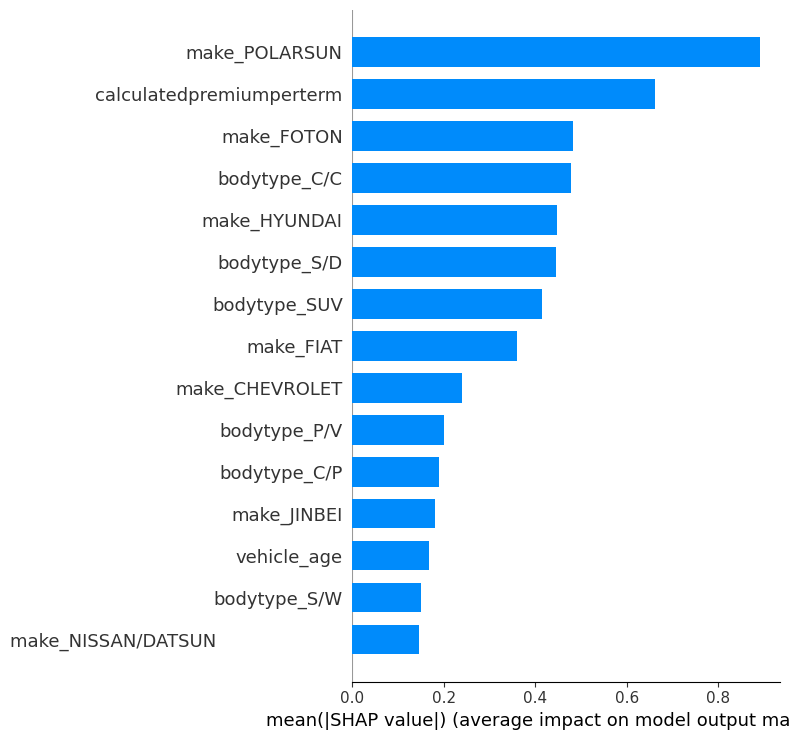

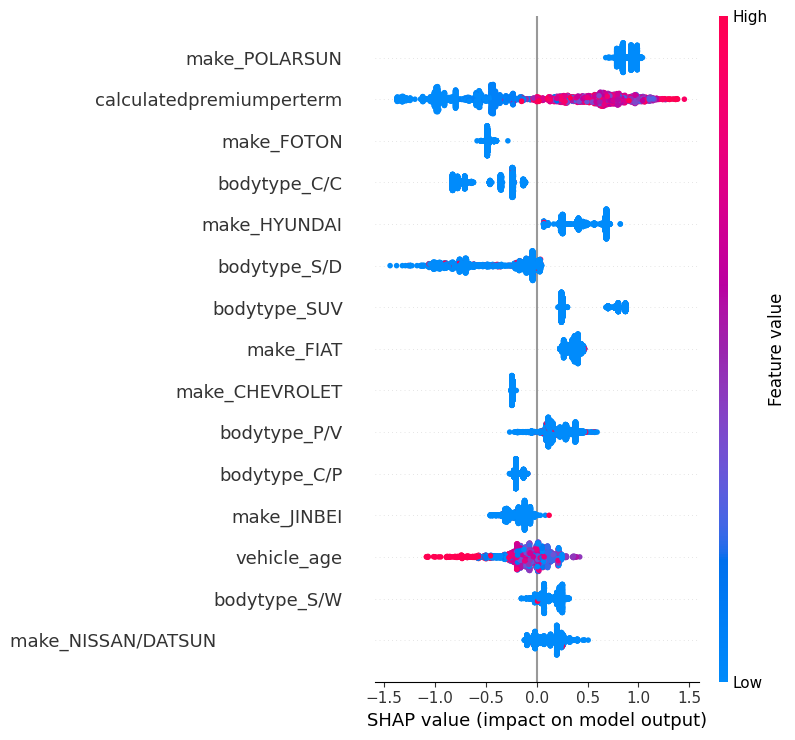

In [7]:
import shap

# Select the best performing model's pipeline (e.g., XGBoost)
best_model_name = "XGBoost" # Or change to whichever model performed best
best_pipeline = results[best_model_name]['pipeline']

# --- Important SHAP setup ---
# 1. Get the preprocessor and the trained model from the pipeline
preprocessor = best_pipeline.named_steps['preprocessor']
model = best_pipeline.named_steps['regressor']

# 2. Transform the training data so SHAP can understand it
X_train_transformed = preprocessor.transform(X_train)

# 3. Get the feature names after one-hot encoding
transformed_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
all_feature_names = numerical_features.tolist() + transformed_feature_names

# Convert the transformed data (which might be sparse) to a dense array for SHAP
X_train_transformed_dense = X_train_transformed.toarray() if hasattr(X_train_transformed, "toarray") else X_train_transformed
X_train_transformed_df = pd.DataFrame(X_train_transformed_dense, columns=all_feature_names)

# --- Explain the model's predictions using SHAP ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed_df)

# --- Visualize the results ---
print("\n--- SHAP Feature Importance ---")
# Plot the summary plot to see the most important features
shap.summary_plot(shap_values, X_train_transformed_df, plot_type="bar", max_display=15)
shap.summary_plot(shap_values, X_train_transformed_df, max_display=15)